## Implementation of GraphSAGE

Based on the paper: <i>Inductive Representation Learning on Large Graphs</i>. This implementation does not use mini-batches, nor does it use sampled fixed-sized neighborhoods.

In [1]:
import numpy as np
import tensorflow as tf
import spektral
import random
import scipy
from sklearn.utils import shuffle
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input,Dense,Reshape,Activation,Flatten,Concatenate,Embedding,Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import balanced_accuracy_score

import warnings
warnings.filterwarnings('ignore')

### CORA Dataset

2708 scientific publications, each represented by 1433 binary-word-count features, with 7 unique classes of papers.

In [2]:
graph = spektral.datasets.citation.Citation('cora',random_split=False,normalize_x=False)
graph = graph[0]
graph

Graph(n_nodes=2708, n_node_features=1433, n_edge_features=None, n_labels=7)

In [3]:
# a: adjacency matrix (edge weights are 1 or 0, undirected graph), x: node features, y: labels
a,x,y = graph['a'],graph['x'],graph['y']
y = np.argmax(y,axis=-1).astype("int32")
a = np.asarray(a.todense())
d = np.diag(np.sum(a,axis=-1)) # degree matrix
print(a.shape,x.shape,y.shape,d.shape)
print(a.dtype,x.dtype,y.dtype,d.dtype)

(2708, 2708) (2708, 1433) (2708,) (2708, 2708)
float32 float32 int32 float32


In [4]:
neighbors = [] # nested list of neighborhood-nodes(indices) for each vertex-node
for i in range(len(a)):
    neighbors.append(list(np.nonzero(a[i,:])[0]))

print(len(neighbors))
print(neighbors[0:3])

2708
[[633, 1862, 2582], [2, 652, 654], [1, 332, 1454, 1666, 1986]]


### GraphSAGE & CORA Classification

In [5]:
# creating the train,test sets - getting indices for each
indices = np.array([i for i in range(len(y))])
indices_per_class = [indices[y==i] for i in range(7)]
test_indices = np.hstack([class_i[0:50] for class_i in indices_per_class]) # equal number of all classes
train_indices = np.hstack([class_i[50:] for class_i in indices_per_class])
test_y = y[test_indices]
train_y = y[train_indices]

train_mask = np.zeros(y.shape).astype("float32") # getting loss mask so that only train data used to update params
train_mask[train_indices]=1

print(train_indices.shape,test_indices.shape,train_mask.shape)
print(train_y.shape,test_y.shape)

(2358,) (350,) (2708,)
(2358,) (350,)


In [6]:
dense_1 = Dense(128,activation="relu")
dense_2 = Dense(128,activation="relu")
dense_3 = Dense(128,activation="relu")
dense_4 = Dense(7,activation=None) # logits

pool_d1 = Dense(128,activation="relu")
pool_d2 = Dense(128,activation="relu")
pool_d3 = Dense(128,activation="relu")
pool_d4 = Dense(128,activation="relu")

scc_loss = SparseCategoricalCrossentropy(from_logits=True)

In [7]:
def gcn_forward(dense,pool_d,layer_in,neighbors):
    """ single layer forward pass of GCN
    """
    neighbor_rep = pool_d(layer_in)
    neighbor_rep = tf.stack([tf.math.reduce_max(tf.gather(neighbor_rep,lis,batch_dims=0),axis=0) for lis in neighbors])
    layer_in = tf.concat([layer_in,neighbor_rep],axis=-1) # layer_in also are the node representations of prev layer
    layer_out = dense(layer_in)
    # layer_out = tf.linalg.normalize(layer_out,axis=-1)[0] # normalizing node representations to unit length
    return layer_out,layer_in

In [9]:
optimizer=Adam(lr=0.001)
epochs=50

for epoch_i in range(epochs): # full-batch gradient descent
    losses = []
    layer_in = x
    with tf.GradientTape() as tape:
        layer_in,_ = gcn_forward(dense_1,pool_d1,layer_in,neighbors)
        layer_in,_ = gcn_forward(dense_2,pool_d2,layer_in,neighbors)
        layer_in,_ = gcn_forward(dense_3,pool_d3,layer_in,neighbors)
        logits,layer_in = gcn_forward(dense_4,pool_d4,layer_in,neighbors)
        loss = scc_loss(y,logits,sample_weight=train_mask) # only use training data
        
    gradients = tape.gradient(loss,dense_1.trainable_variables+dense_2.trainable_variables+dense_3.trainable_variables+dense_4.trainable_variables+pool_d1.trainable_variables+pool_d2.trainable_variables+pool_d3.trainable_variables+pool_d4.trainable_variables)
    optimizer.apply_gradients(zip(gradients,dense_1.trainable_variables+dense_2.trainable_variables+dense_3.trainable_variables+dense_4.trainable_variables+pool_d1.trainable_variables+pool_d2.trainable_variables+pool_d3.trainable_variables+pool_d4.trainable_variables))
    losses.append(float(loss))
    
    node_predictions = np.argmax(logits.numpy(),axis=-1)
    test_pred,train_pred = node_predictions[test_indices],node_predictions[train_indices]
    train_acc = balanced_accuracy_score(train_y,train_pred)
    test_acc = balanced_accuracy_score(test_y,test_pred)
    print("epoch {}; loss:{}, train_acc:{}, test_acc:{}".format(epoch_i+1,round(sum(losses)/len(losses),4),round(train_acc,4),round(test_acc,4)))        

epoch 1; loss:1.6243, train_acc:0.15, test_acc:0.1486
epoch 2; loss:1.5473, train_acc:0.144, test_acc:0.1429
epoch 3; loss:1.4709, train_acc:0.1429, test_acc:0.1429
epoch 4; loss:1.4031, train_acc:0.1599, test_acc:0.16
epoch 5; loss:1.3256, train_acc:0.2444, test_acc:0.2514
epoch 6; loss:1.2394, train_acc:0.2917, test_acc:0.2714
epoch 7; loss:1.1462, train_acc:0.3417, test_acc:0.3114
epoch 8; loss:1.0491, train_acc:0.3684, test_acc:0.3429
epoch 9; loss:0.9484, train_acc:0.4323, test_acc:0.4
epoch 10; loss:0.8491, train_acc:0.5813, test_acc:0.5514
epoch 11; loss:0.7498, train_acc:0.6404, test_acc:0.6314
epoch 12; loss:0.6548, train_acc:0.6795, test_acc:0.6571
epoch 13; loss:0.5675, train_acc:0.7108, test_acc:0.6829
epoch 14; loss:0.4955, train_acc:0.758, test_acc:0.7257
epoch 15; loss:0.4385, train_acc:0.8219, test_acc:0.7886
epoch 16; loss:0.3985, train_acc:0.8534, test_acc:0.8286
epoch 17; loss:0.364, train_acc:0.8567, test_acc:0.8257
epoch 18; loss:0.3395, train_acc:0.8607, test_acc:

### Visualization

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [11]:
tsne_emb = TSNE(n_components=2).fit_transform(layer_in.numpy())
print(tsne_emb.shape)

(2708, 2)


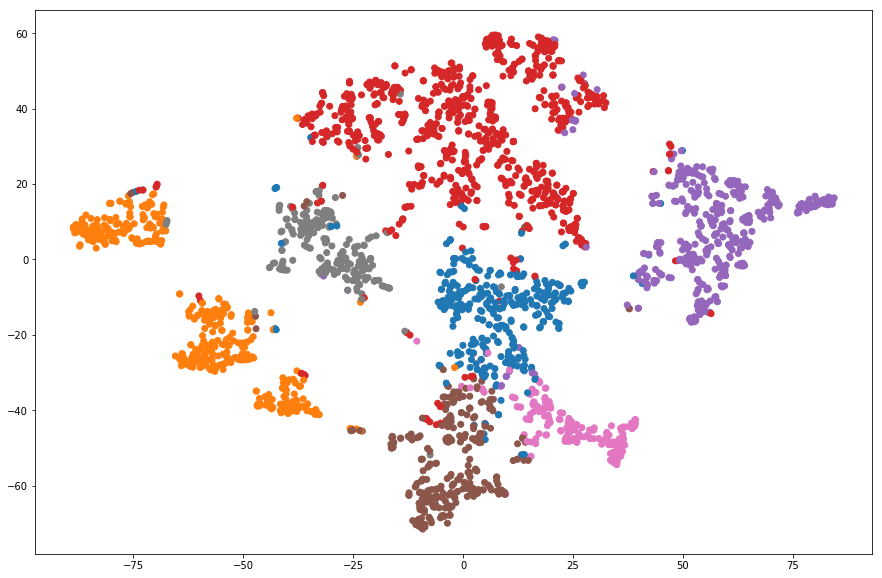

In [12]:
color_mapper = {0:'#1f77b4',1:'#7f7f7f',2:'#ff7f0e',3:'#d62728',4:'#9467bd',5:'#8c564b',6:'#e377c2'}
colors = [color_mapper[y[i]] for i in range(len(y))]

plt.figure(figsize=(15,10))
plt.scatter(tsne_emb[:,0],tsne_emb[:,1],c=colors)
plt.show()